<a href="https://colab.research.google.com/github/johnlocke333/xray_image_classification/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Preparation**


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
import numpy as np
import os

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip -uq "/content/drive/My Drive/xray.zip" -d "/content/drive/My Drive/xray"

In [12]:
# Directory path
train_data_dir = '/content/drive/MyDrive/xray/chest_xray/chest_xray/train'
test_data_dir = '/content/drive/MyDrive/xray/chest_xray/chest_xray/test'
valid_data_dir = '/content/drive/MyDrive/xray/chest_xray/chest_xray/val'


In [8]:
def get_reshape_images(dir, bs):
# Get all the data in the directory data/validation (5216 images), and reshape them
  generator = ImageDataGenerator().flow_from_directory(
          dir, target_size=(64, 64), batch_size=bs)

# Create the datasets
  images, labels = next(generator)
  return images, labels

In [9]:
train_images, train_labels = get_reshape_images(train_data_dir, 5216)

Found 5216 images belonging to 2 classes.


In [15]:
test_images, test_labels = get_reshape_images(test_data_dir, 624)

Found 624 images belonging to 2 classes.


In [14]:
valid_images, valid_labels = get_reshape_images(valid_data_dir, 16)

Found 16 images belonging to 2 classes.


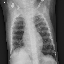

In [16]:
array_to_img(train_images[10])

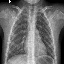

In [17]:
array_to_img(test_images[10])

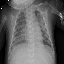

In [18]:
array_to_img(valid_images[3])

In [26]:
 def reshape_input_image_label(images, m, labels):
  img_unrow = images.reshape(m, -1).T
  labels_final = labels.T[[1]]
  return img_unrow, labels_final

In [27]:
train_img_unrow, train_label_final = reshape_input_image_label(train_images, 5216, train_labels)

In [28]:
test_img_unrow, test_label_final = reshape_input_image_label(test_images, 624, test_labels)

In [29]:
valid_img_unrow, valid_label_final = reshape_input_image_label(valid_images, 16, valid_labels)

In [30]:
np.shape(train_img_unrow)

(12288, 5216)

In [31]:
np.shape(test_img_unrow)

(12288, 624)

In [32]:
np.shape(valid_img_unrow)

(12288, 16)

In [34]:
np.shape(train_label_final)

(1, 5216)

In [35]:
np.shape(test_label_final)

(1, 624)

In [36]:
np.shape(valid_label_final)

(1, 16)

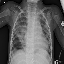

In [37]:
array_to_img(train_images[240])

In [39]:
train_label_final[:,240]

array([1.], dtype=float32)

In [41]:
def standardize(img_unrow):
  img_final = img_unrow/255
  return img_final

In [42]:
train_img_final = standardize(train_img_unrow)

In [43]:
test_img_final= standardize(test_img_unrow)

In [44]:
valid_img_final = standardize(valid_img_unrow)